In [41]:

import math
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Activation, ZeroPadding2D, Add, GlobalAveragePooling2D, Dropout
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping



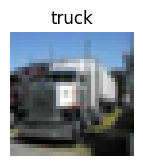

In [36]:

CLASSES = ["airplane", "automobile", "bird", "cat", "deer",  "dog", "frog", "horse", "ship", "truck"]
N_CLASSES = len(CLASSES)
BATCH_SIZE = N_FILTERS = 64

def show_random_sample(x_train, y_train):
    # show random images from training data
    rows, cols = 2, 8
    fig = plt.figure(figsize=(2*cols - 1, 2.5*rows - 1))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(y_train))
            ax = fig.add_subplot(rows, cols, i*rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(x_train[random_index, :])
            ax.set_title(CLASSES[y_train[random_index, 0]])
            plt.show()

def plot_model_performance(history, n_epochs):

    epochs = range(1, n_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], 'bo', label='Training Accuracy')
    plt.plot(history['val_accuracy'], 'orange', label="Validation Accuracy")
    plt.title('Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], 'bo', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'orange', label='Validation Loss')
    plt.title(f'Cross-Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_random_sample(x_train, y_train)


In [37]:


class BasicResNet():

    def __init__(self, x_test, y_test, x_train, y_train):

        self.model = self.create_resnet_model()
        self.X_test, self.Y_test, self.X_train, self.Y_train = self.init_data(x_test, y_test, x_train, y_train)
        self.callback = LearningRateScheduler(self.scheduler)
        self.early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    def scheduler(self, epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * math.exp(-0.1)

    def init_data(self, x_test, y_test, x_train, y_train):

        print("Train samples:", x_train.shape, y_train.shape)
        print("Test samples:", x_test.shape, y_test.shape)

        X_train = x_train.astype('float32')/255
        X_test = x_test.astype('float32')/255

        Y_train = to_categorical(y_train, N_CLASSES)
        Y_test = to_categorical(y_test, N_CLASSES)

        return X_test, Y_test, X_train, Y_train

    def create_generators(self):

        x_val, partial_x_train = self.X_train[:10000], self.X_train[10000:]
        y_val, partial_y_train = self.Y_train[:10000], self.Y_train[10000:]

        gen = ImageDataGenerator(
            rotation_range=8,
            width_shift_range=0.08,
            shear_range=0.3,
            height_shift_range=0.08,
            zoom_range=0.08,
            horizontal_flip=True
            )
        train_generator = gen.flow(partial_x_train, partial_y_train, batch_size=BATCH_SIZE)

        val_gen = ImageDataGenerator()
        val_generator = val_gen.flow(x_val, y_val, batch_size=BATCH_SIZE)

        return train_generator, val_generator

    def create_resnet_model(self):

        # Define the input as a tensor with Zero-Padding
        X_input = Input((32,32,3))
        X = ZeroPadding2D((3, 3))(X_input)

        # ---------------Stage 1---------------
        X = Conv2D(N_FILTERS, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
        X = Activation('relu')(X)
        X = MaxPooling2D((3, 3), strides=(2, 2))(X)

        # ---------------Stage 2---------------
        # Save the input value
        X_shortcut = X

        # conv2d layer --> batch norm layer --> relu activation layer
        # X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), padding='same', name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
        X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
        X = Activation('relu')(X)

        # add extra conv2d layer chain to get equal size when combining Stage 1 and Stage 2
        # X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), padding='same', name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
        X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
        X = Activation('relu')(X)

        # final conv2d layer and normalization
        # X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), padding='same', name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
        X = Conv2D(N_FILTERS, (3, 3), strides = (1, 1), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
        # Add X_shortcut before doing final activation
        X = Add()([X, X_shortcut])
        X = Activation('relu')(X)

        # output layer to predict class
        # X = Flatten()(X)
        X = GlobalAveragePooling2D()(X)  # Replace Flatten with GlobalAveragePooling2D
        X = Dropout(0.1)(X)  # Add Dropout for regularization
        X = Dense(N_CLASSES, activation='softmax', name=f'fc{N_CLASSES}', kernel_initializer = glorot_uniform(seed=0))(X)

        # Create model
        print()
        model = Model(inputs= X_input, outputs= X, name='ResNet')
        model.summary()
        print()

        return model

    def _fit(self, opt, n_epochs):

        train_generator, val_generator = self.create_generators()

        self.model.compile(loss='categorical_crossentropy',
                            optimizer=opt,
                            metrics=['accuracy']
                            )

        history = self.model.fit(
                                train_generator,
                                epochs=n_epochs,
                                validation_data=val_generator,
                                callbacks=[self.callback, self.early_stop]
                                )

        return history.history

    def _evaluate(self):
        score = self.model.evaluate(self.X_test, self.Y_test)
        print()
        print('Test accuracy: ', score[1])
        print()



In [38]:

nn = BasicResNet(x_test, y_test, x_train, y_train)

n_epochs = 10



Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_7 (ZeroPadd  (None, 38, 38, 3)            0         ['input_8[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d_7[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']         

Epoch 1/10
625/625 [==============================] - 24s 34ms/step - loss: 1.5819 - accuracy: 0.4339 - val_loss: 1.3840 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 21s 34ms/step - loss: 1.2467 - accuracy: 0.5547 - val_loss: 1.3063 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 21s 34ms/step - loss: 1.1085 - accuracy: 0.6063 - val_loss: 1.1239 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 21s 34ms/step - loss: 1.0150 - accuracy: 0.6419 - val_loss: 1.3399 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 21s 34ms/step - loss: 0.9591 - accuracy: 0.6614 - val_loss: 1.3602 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 22s 35ms/step - loss: 0.9152 - accuracy: 0.6773 - val_loss: 0.8266 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 22s 

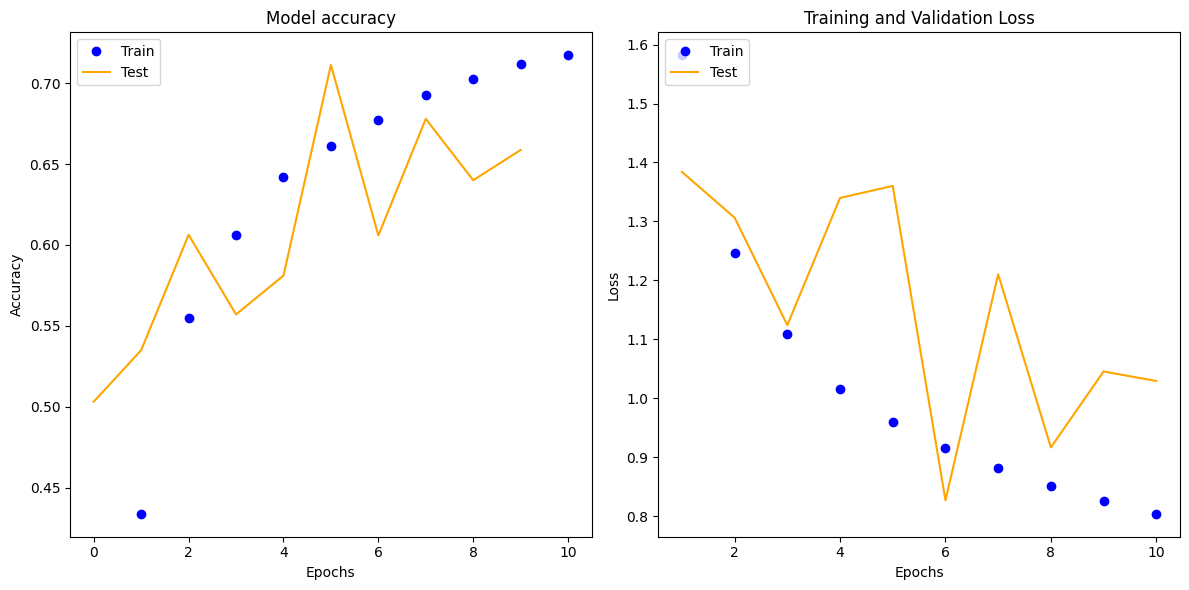

In [39]:

opt = Adam()
history = nn._fit(opt, n_epochs)
nn._evaluate()

plot_model_performance(history, n_epochs)



Epoch 1/10
625/625 [==============================] - 23s 34ms/step - loss: 0.7252 - accuracy: 0.7480 - val_loss: 0.7836 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 21s 34ms/step - loss: 0.7089 - accuracy: 0.7540 - val_loss: 0.7914 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 21s 34ms/step - loss: 0.6943 - accuracy: 0.7570 - val_loss: 0.9246 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 21s 34ms/step - loss: 0.6930 - accuracy: 0.7589 - val_loss: 0.6770 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 21s 34ms/step - loss: 0.6918 - accuracy: 0.7587 - val_loss: 0.6726 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 21s 34ms/step - loss: 0.6838 - accuracy: 0.7632 - val_loss: 0.7402 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 21s 

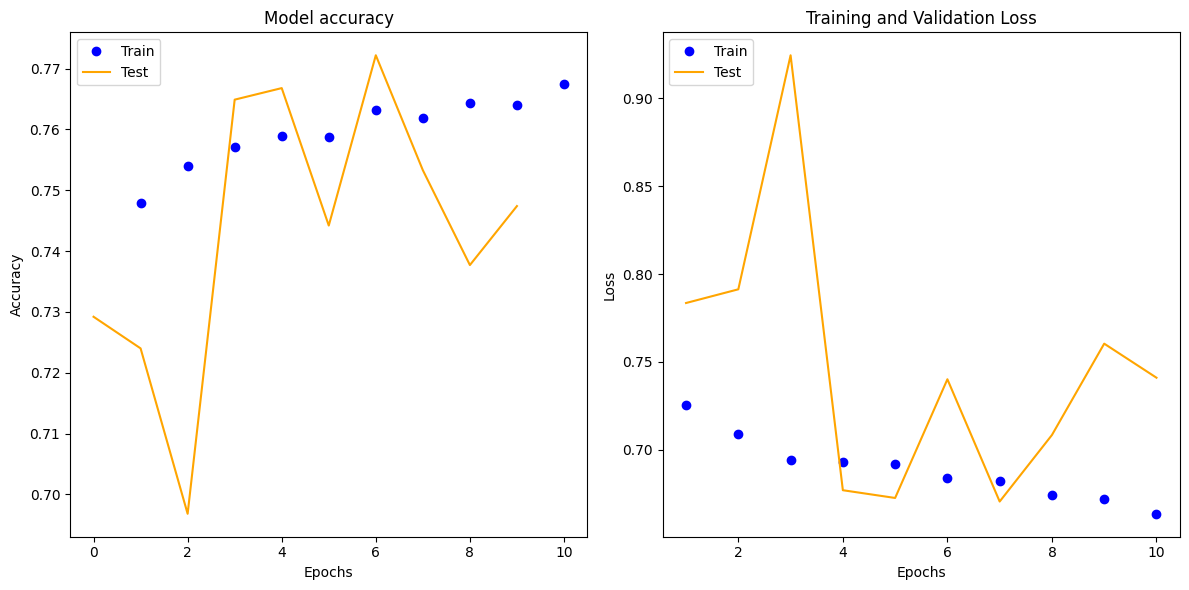

In [40]:


opt = SGD(learning_rate=0.001, momentum=0.9)
history = nn._fit(opt, n_epochs)
nn._evaluate()

plot_model_performance(history, n_epochs)

